<a href="https://colab.research.google.com/github/cesaraugustopereirabr/Reconhecimento_Facial/blob/main/Reconhecimento_Facial_BRICS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⬆️ Envie várias imagens de referência (ex: sheldon_1.jpg, sheldon_2.jpg, amy_1.jpg...)


Saving Cyril Ramaphosa_1.jpg to Cyril Ramaphosa_1.jpg
Saving Cyril Ramaphosa_2.jpg to Cyril Ramaphosa_2.jpg
Saving Cyril Ramaphosa_3.jpg to Cyril Ramaphosa_3.jpg
Saving Cyril Ramaphosa_4.jpg to Cyril Ramaphosa_4.jpg
Saving Lula_1.jpg to Lula_1.jpg
Saving Narendra Modi_1.jpg to Narendra Modi_1.jpg
Saving Narendra Modi_2.jpg to Narendra Modi_2.jpg
Saving Narendra Modi_3.jpeg to Narendra Modi_3.jpeg
Saving Narendra Modi_4.jpg to Narendra Modi_4.jpg
Saving Narendra Modi_5.jpg to Narendra Modi_5.jpg
Saving Sergey Lavrov_1.jpg to Sergey Lavrov_1.jpg
Saving Sergey Lavrov_2.jpeg to Sergey Lavrov_2.jpeg
Saving Sergey Lavrov_3.jpg to Sergey Lavrov_3.jpg
Saving Sergey Lavrov_4.jpeg to Sergey Lavrov_4.jpeg
Saving Sergey Lavrov_5.jpeg to Sergey Lavrov_5.jpeg
Saving Xi Jinping_1.jpg to Xi Jinping_1.jpg

✅ Criando banco de dados com embeddings (modelo: ArcFace)...
✅ Sergey Lavrov_5.jpeg processado como 'Sergey Lavrov'
✅ Narendra Modi_5.jpg processado como 'Narendra Modi'
✅ Xi Jinping_1.jpg processado

Saving lideres.jpg to lideres (1).jpg

🔍 Iniciando detecção e reconhecimento facial...


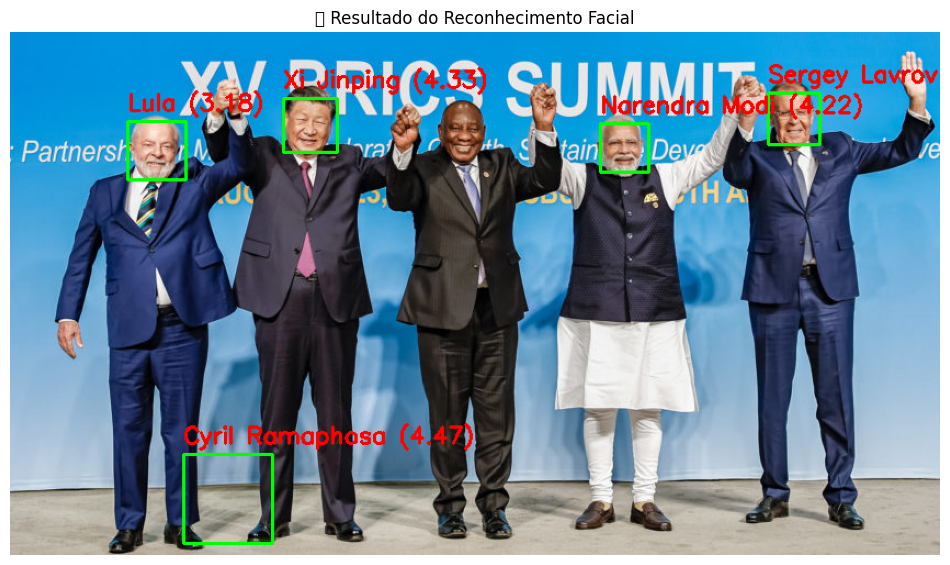

In [10]:
# Instalar bibliotecas necessárias
!pip install deepface opencv-python-headless --quiet

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from deepface import DeepFace
from google.colab import files
from PIL import Image
from collections import defaultdict

# Etapa 1: Upload das imagens de referência
os.makedirs("faces_referencia", exist_ok=True)
print("⬆️ Envie várias imagens de referência (ex: sheldon_1.jpg, sheldon_2.jpg, amy_1.jpg...)")
uploaded = files.upload()

for filename in uploaded.keys():
    os.rename(filename, f"faces_referencia/{filename}")

# Etapa 2: Criar base de embeddings (com múltiplas imagens por pessoa)
print("\n✅ Criando banco de dados com embeddings (modelo: ArcFace)...")
face_db = defaultdict(list)
model_name = "ArcFace"

for filename in os.listdir("faces_referencia"):
    name = "_".join(os.path.splitext(filename)[0].split("_")[:-1])  # sheldon_1 -> sheldon
    img_path = os.path.join("faces_referencia", filename)

    try:
        embedding_obj = DeepFace.represent(img_path=img_path, model_name=model_name, enforce_detection=True)[0]
        face_db[name].append(embedding_obj["embedding"])
        print(f"✅ {filename} processado como '{name}'")
    except Exception as e:
        print(f"⚠️ Erro ao processar {filename}: {e}")

# Etapa 3: Upload da imagem principal
print("\n⬆️ Agora envie a imagem com várias pessoas para reconhecimento:")
uploaded_test = files.upload()
test_img_path = list(uploaded_test.keys())[0]

# Etapa 4: Reconhecimento facial
print("\n🔍 Iniciando detecção e reconhecimento facial...")
img_bgr = cv2.imread(test_img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

detections = DeepFace.extract_faces(img_path=test_img_path, detector_backend='opencv', enforce_detection=False)
threshold = 13  # mais tolerante

for i, face_info in enumerate(detections):
    facial_area = face_info['facial_area']
    x, y, w, h = facial_area['x'], facial_area['y'], facial_area['w'], facial_area['h']

    # Recortar o rosto detectado
    face_crop = img_rgb[y:y+h, x:x+w]
    temp_face_path = f"face_temp_{i}.jpg"
    Image.fromarray(face_crop).save(temp_face_path)

    try:
        embedding_obj = DeepFace.represent(img_path=temp_face_path, model_name=model_name, enforce_detection=False)[0]
        embedding = embedding_obj["embedding"]
    except Exception as e:
        print(f"⚠️ Erro ao gerar embedding para rosto {i}: {e}")
        continue

    # Comparação com todos os rostos da base
    best_match = "desconhecido"
    min_dist = float("inf")

    for name, ref_embeddings in face_db.items():
        for ref_embedding in ref_embeddings:
            dist = np.linalg.norm(np.array(embedding) - np.array(ref_embedding))
            if dist < min_dist:
                min_dist = dist
                best_match = name

    label = best_match if min_dist < threshold else "desconhecido"

    # Desenhar na imagem
    cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(img_rgb, f"{label} ({min_dist:.2f})", (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

# Exibir resultado final
plt.figure(figsize=(12, 8))
plt.imshow(img_rgb)
plt.axis('off')
plt.title("🔎 Resultado do Reconhecimento Facial")
plt.show()
